# Store Sales competition

Цель: предсказать 'sales'. 

## Первичная обработка данных

In [243]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
from matplotlib import pyplot as plt 
import seaborn as sns 

import os
import warnings
warnings.filterwarnings(action="ignore")

In [244]:
print("CORE DATA:\n", os.listdir("./data/"))

CORE DATA:
 ['oil.csv', 'stores.csv', 'train.csv', 'holidays_events.csv', 'transactions.csv', 'test.csv']


In [245]:
train_data = pd.read_csv("./data/train.csv", parse_dates=['date'])
test_data = pd.read_csv("./data/test.csv", parse_dates=['date'])
test_idx = test_data['id']

In [246]:
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [247]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

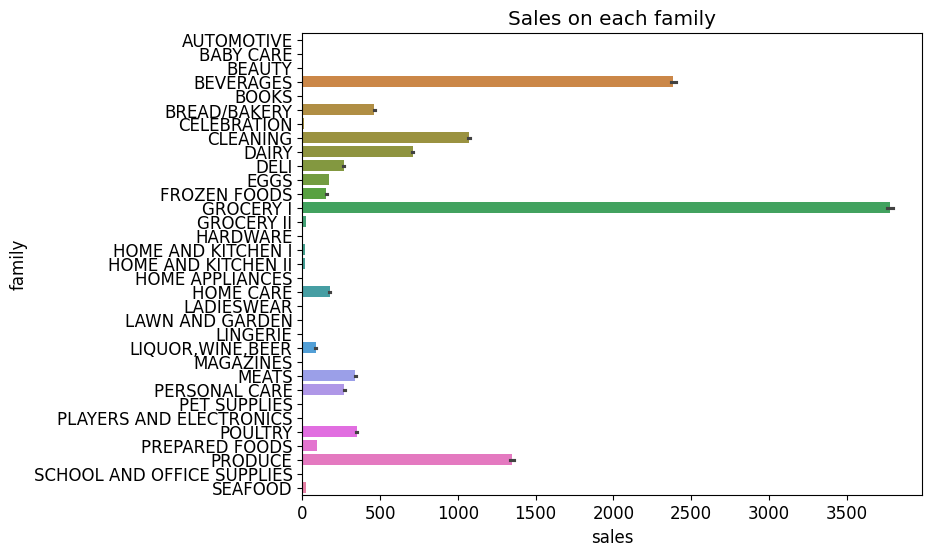

In [249]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

sns.barplot(data=train_data, x='sales', y='family', hue='family')
plt.title("Sales on each family")

plt.show()

In [250]:
oil = pd.read_csv("./data/oil.csv", parse_dates=['date'])
oil = oil.rename(columns={"dcoilwtico": "oil_price"})

oil.fillna({"oil_price": np.nanmean(oil["oil_price"])}, inplace=True)
oil.head()

,date,oil_price
0,2013-01-01,67.714366
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000


In [251]:
train_data['is_train']=True
test_data['is_train']=False

full_data = pd.concat([train_data, test_data], sort=False)

full_data = full_data.merge(oil, on=["date"], how="left")
full_data.head()

,id,date,store_nbr,family,sales,onpromotion,is_train,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,True,67.714366
1,1,2013-01-01,1,BABY CARE,0.0,0,True,67.714366
2,2,2013-01-01,1,BEAUTY,0.0,0,True,67.714366
3,3,2013-01-01,1,BEVERAGES,0.0,0,True,67.714366
4,4,2013-01-01,1,BOOKS,0.0,0,True,67.714366


In [252]:
transactions = pd.read_csv("./data/transactions.csv", parse_dates=['date'])

full_data = full_data.merge(transactions, how="left", on=["date", "store_nbr"])
full_data.fillna(0, inplace=True)

In [253]:
full_data.head()

,id,date,store_nbr,family,sales,onpromotion,is_train,oil_price,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,True,67.714366,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,True,67.714366,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,True,67.714366,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,True,67.714366,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,True,67.714366,0.0


In [254]:
full_data['year'] = full_data['date'].dt.year
full_data['month'] = full_data['date'].dt.month
full_data['day'] = full_data['date'].dt.dayofweek

full_data['quarter'] = full_data['date'].dt.quarter
full_data['is_start'] = full_data['date'].dt.is_month_start.astype(int)
full_data['is_end'] = full_data['date'].dt.is_month_end.astype(int)

In [255]:
g = full_data.groupby(['store_nbr', 'family'])['sales']
for lag in [7, 14, 28, 90]:
    full_data[f"lag_{lag}"] = g.shift(lag)

for window in [7, 14, 28]:
    full_data[f"window_mean_{window}"] = g.transform(lambda x: x.rolling(window=window).mean())
    full_data[f"window_std_{window}"] = g.transform(lambda x: x.rolling(window=window).std())

full_data.fillna(0, inplace=True)
full_data.sample(6)

,id,date,store_nbr,family,sales,onpromotion,is_train,oil_price,transactions,year,...,lag_7,lag_14,lag_28,lag_90,window_mean_7,window_std_7,window_mean_14,window_std_14,window_mean_28,window_std_28
133359,133359,2013-03-16,50,CELEBRATION,0.000,0,True,0.00,3505.0,2013,...,0.000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1300559,1300559,2015-01-02,5,PREPARED FOODS,145.483,1,True,52.72,1772.0,2015,...,131.713,99.770,79.016000,94.236,106.144143,49.731658,111.596357,39.411387,108.977393,30.198366
1786031,1786031,2015-10-02,22,BREAD/BAKERY,0.000,0,True,45.54,0.0,2015,...,0.000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2285088,2285088,2016-07-09,25,BEVERAGES,2572.000,20,True,0.00,1020.0,2016,...,2643.000,2243.000,1819.000000,2149.000,1627.428571,561.112246,1609.928571,544.738959,1540.428571,443.892665
1674466,1674466,2015-07-31,41,GROCERY II,16.000,0,True,47.11,1032.0,2015,...,13.000,20.000,18.000000,28.000,26.000000,12.476645,23.928571,11.492233,24.000000,9.985174
2653394,2653394,2017-02-01,9,PREPARED FOODS,126.465,12,True,53.90,2184.0,2017,...,74.240,147.319,75.201004,174.430,111.888571,40.886872,123.233428,48.811776,126.482643,44.779901


In [256]:
holidays = pd.read_csv("./data/holidays_events.csv", parse_dates=['date'])
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [257]:
holidays_selected=holidays[holidays['transferred']==False]

full_data_1 = full_data.merge(holidays_selected, on=['date'], how="left")
full_data_1.head()

,id,date,store_nbr,family,sales,onpromotion,is_train,oil_price,transactions,year,...,window_std_7,window_mean_14,window_std_14,window_mean_28,window_std_28,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,True,67.714366,0.0,2013,...,0.0,0.0,0.0,0.0,0.0,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,True,67.714366,0.0,2013,...,0.0,0.0,0.0,0.0,0.0,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,True,67.714366,0.0,2013,...,0.0,0.0,0.0,0.0,0.0,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,True,67.714366,0.0,2013,...,0.0,0.0,0.0,0.0,0.0,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,True,67.714366,0.0,2013,...,0.0,0.0,0.0,0.0,0.0,Holiday,National,Ecuador,Primer dia del ano,False


In [268]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as bst 
import lightgbm as lgb

In [262]:
def calc_rmsle(y_true, y_pred):
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)

    true_log = np.log1p(y_true)
    pred_log = np.log1p(y_pred)

    msle = np.mean( (true_log - pred_log)**2 )
    return np.sqrt(msle)

In [272]:
X = full_data[full_data['is_train']==True]
y = X['sales']
X = X.drop(['is_train', 'date', 'id'], axis=1, errors='ignore')
X = X.drop(['lag_7', 'lag_14', 'lag_28', 'lag_90', 'window_mean_7', 'window_mean_14', 'window_mean_28', 'window_std_7', 'window_std_14', 'window_std_28', 'sales'], axis=1,
          errors='ignore')

numerics = X.select_dtypes(include=[np.number]).columns
categorics = X.select_dtypes(exclude=[np.number]).columns

X[numerics] = MinMaxScaler().fit_transform(X[numerics])

for cat in categorics:
    X[cat] = LabelEncoder().fit_transform(X[cat])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=0)

model_bst = bst.XGBRegressor(n_estimators=1000, objective='count:poisson', learning_rate=.05, random_state=0, base_score = np.log1p(np.mean(y_train)))
model_bst.fit(X_train, y_train)

val_pred = model_bst.predict(X_val)
print("RMSLE: %.4f" % calc_rmsle(val_pred, y_val))

RMSLE: 1.0459


In [ ]:
X_test = full_data[full_data['is_train']==False]
X_test.drop(['lag_7', 'lag_14', 'lag_28', 'lag_90', 'window_mean_7', 'window_mean_14', 'window_mean_28', 'window_std_7', 'window_std_14', 'window_std_28', 'is_train', 'id', 'sales'], axis=1,
          errors='ignore', inplace=True)

print(X_test.head())
X_test = trans.transform(X_test)
y_sub = model_bst.predict(X_test)
sub = pd.DataFrame({'id': test_idx, 'sales': y_sub})
sub.head()

In [ ]:
sub.to_csv('456.csv', index=False)

Данное решение - топ 499 из 708 (9.07.2025)

(RMSLE на валидации: RMSLE: 1.2389)

(UPD: RMSLE: 1.0459)